In [1]:
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import expit # Numerically stable sigmoid function
from scipy.optimize import curve_fit

# Import Data

# Set print options to suppress scientific notation
np.set_printoptions(suppress=True)

df_profit_list_all = []

for year in [2014]:
    
    
    period = ['may-jun', 'jun-jul']

    # Import data
    if year == 2014:
        X = np.load('../data/processed/data_2014.npz')

    elif year == 2015:
        X = np.load('../data/processed/data_2015.npz')

    elif year == 2016:
        X = np.load('../data/processed/data_2016.npz')
        
    elif year == 2017:
        X = np.load('../data/processed/data_2017.npz')

    N = X['N']

    distance = X['distance']
    dist = X['distance']
    #tI1 = X['tI1'].reshape(N,1)
    #tI2 = X['tI2'].reshape(N,1)
    sI2 = X['sI2'].reshape(N,1)

    y_apr = X['y_apr'].reshape(N,1)
    y_may = X['y_may'].reshape(N,1)
    y_jun = X['y_jun'].reshape(N,1)
    y_jul = X['y_jul'].reshape(N,1)

    n_apr = X['n_apr'].reshape(N,1)
    n_may = X['n_may'].reshape(N,1)
    n_jun = X['n_jun'].reshape(N,1)
    n_jul = X['n_jul'].reshape(N,1)

    area_apr = X['a_apr'].reshape(N,1)
    a_apr = X['a_apr'].reshape(N,1)
    a_may = X['a_may'].reshape(N,1)
    a_jun = X['a_jun'].reshape(N,1)
    a_jul = X['a_jul'].reshape(N,1)

    w_apr = X['wind_apr']
    w_may = X['wind_may']
    w_jun = X['wind_jun']
    w_jul = X['wind_jul']

    sI1_apr = X['sI1_apr'].reshape(N,1)
    sI1_may = X['sI1_may'].reshape(N,1)
    sI1_jun = X['sI1_jun'].reshape(N,1)
    sI1_jul = X['sI1_jul'].reshape(N,1)

    s_apr = X['s_apr'].reshape(N,1)
    s_may = X['s_may'].reshape(N,1)
    s_jun = X['s_jun'].reshape(N,1)
    s_jul = X['s_jul'].reshape(N,1)

    # Convert to float64
    dist = dist.astype(np.float64)
    #tI1 = tI1.astype(np.float64)
    #tI2 = tI2.astype(np.float64)
    sI2 = sI2.astype(np.float64)

    y_apr = y_apr.astype(np.float64)
    y_may = y_may.astype(np.float64)
    y_jun = y_jun.astype(np.float64)
    y_jul = y_jul.astype(np.float64)

    n_apr = n_apr.astype(np.float64)
    n_may = n_may.astype(np.float64)
    n_jun = n_jun.astype(np.float64)
    n_jul = n_jul.astype(np.float64)

    a_apr = a_apr.astype(np.float64)
    a_may = a_may.astype(np.float64)
    a_jun = a_jun.astype(np.float64)
    a_jul = a_jul.astype(np.float64)

    w_apr = w_apr.astype(np.float64)
    w_may = w_may.astype(np.float64)
    w_jun = w_jun.astype(np.float64)
    w_jul = w_jul.astype(np.float64)

    sI1_apr = sI1_apr.astype(np.float64)
    sI1_may = sI1_may.astype(np.float64)
    sI1_jun = sI1_jun.astype(np.float64)
    sI1_jul = sI1_jul.astype(np.float64)

    s_apr = s_apr.astype(np.float64)
    s_may = s_may.astype(np.float64)
    s_jun = s_jun.astype(np.float64)
    s_jul = s_jul.astype(np.float64)

    area_hectares = a_apr
    
    # DISTANCED BASED NETWORK

    import networkx as nx
    import folium
    from matplotlib.colors import LinearSegmentedColormap

    # Read data from CSV file into a pandas DataFrame
    df = pd.read_csv('../data/processed/cost_data.csv', encoding='utf-8')

    num_quantiles = 5

    # Create a linear gradient colormap from blue to red

    cmap = LinearSegmentedColormap.from_list('centrality_colormap', ['blue', 'yellow', 'red'], N=num_quantiles)

    cmap = LinearSegmentedColormap.from_list('approx_inferno', [
        '#FCFFA4',  # Yellow
        '#FCA50A', # Orange
        '#DD513A', # Red-orange
        '#932567', # Dark red
        '#420A68', # Purple
        '#000004' # Black
    ], N=256)

    # Centroid Latitude and Longitude Coordinates
    coord = df[(df['Year'] == year) & (df['Month'] == 'May')][['Centroid Lat', 'Centroid Long']].reset_index(drop=True)

    # Initialize graph
    G = nx.Graph()

    # Add nodes with their coordinates
    for index, row in coord.iterrows():
        G.add_node(index, pos=(row['Centroid Long'], row['Centroid Lat']))

    # min-max scaling for edge weights
    w_may_scaled = (w_may - np.min(w_may)) / (np.max(w_may) - np.min(w_may))
    w_jun_scaled = (w_jun - np.min(w_jun)) / (np.max(w_jun) - np.min(w_jun))
    distance_scaled = (distance - np.min(distance)) / (np.max(distance) - np.min(distance))
    area_apr_scaled = (area_apr - np.min(area_apr)) / (np.max(area_apr) - np.min(area_apr))

    
    # Add edges with weights using the new formula
    for i in G.nodes():
        for j in G.nodes():
            if i < j:  # This ensures that we don't calculate the distance twice
                area_i = area_apr_scaled[i]  # area of yard i
                wind_run_ij = ((w_may_scaled + w_jun_scaled) / 2)[i, j]  # average wind run from yard i to yard j over may and june
                distance_ij = distance_scaled[i, j]  # distance from yard i to yard j
                
                # Calculate edge weight using the provided formula
                weight = area_i * wind_run_ij * np.power(1 + distance_ij, -2)
                
                # Add edge with the calculated weight
                G.add_edge(i, j, weight=weight)

    # Centrality Statistics

    # Now calculate weighted degree centrality manually
    weighted_degree_centrality = {}
    for node in G.nodes():
        weighted_degree = sum(data['weight'] for _, _, data in G.edges(node, data=True))
        weighted_degree_centrality[node] = weighted_degree  # Make sure this is a scalar value


    # Convert centrality to DataFrame for easier manipulation
    degree_centrality_df = pd.DataFrame(list(weighted_degree_centrality.items()), columns=['Node', 'Centrality'])

    # Ensure 'Centrality' column has scalar values
    degree_centrality_df['Centrality'] = degree_centrality_df['Centrality'].apply(lambda x: x if np.isscalar(x) else x[0])

    # Convert centrality to deciles - this will create bins from 0.1 (10th percentile) to 1.0 (100th percentile)
    degree_centrality_df['Centrality_Decile'] = pd.qcut(degree_centrality_df['Centrality'], num_quantiles, labels=range(1, num_quantiles + 1))

    # Since we've labeled the deciles 1 to 10, we need to normalize them to 0-1 for the colormap
    # This means 1 should become 0.1, and 10 should become 1.0, therefore we divide by 10
    degree_centrality_df['Centrality_Decile'] = degree_centrality_df['Centrality_Decile'].astype(int) / num_quantiles

    # Update the nodes with the centrality decile
    for row in degree_centrality_df.itertuples():
        G.nodes[row.Node]['centrality'] = row.Centrality
        # Normalize the centrality decile from 1-10 to 0.1-1.0 for colormap
        G.nodes[row.Node]['centrality_decile'] = row.Centrality_Decile

    # Initialize the map centered around the mean latitude and longitude of your nodes
    m = folium.Map(location=[coord['Centroid Lat'].mean(), coord['Centroid Long'].mean()], zoom_start=11)

    # Get node positions
    pos = nx.get_node_attributes(G, 'pos')

    # Function to convert RGB to Hex
    def rgb_to_hex(rgb):
        return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

    # Get the colors for each node based on the centrality decile
    # Use matplotlib to get the RGB values, then convert to Hex
    node_colors = [rgb_to_hex(cmap(decile)) for decile in degree_centrality_df['Centrality_Decile']]

    # Add the nodes to the map using the hexadecimal color values
    for node, color in zip(G.nodes(), node_colors):
        pos_node = pos[node]
        folium.CircleMarker(
            location=(pos_node[1], pos_node[0]),  # Latitude and Longitude for Folium
            radius=5,  # Adjust size as needed
            color=color,  # Border color
            fill=True,
            fill_color=color,  # Fill color
            tooltip=f'Decile: {G.nodes[node]["centrality_decile"]:.1f}, Centrality: {G.nodes[node]["centrality"]:.4f}'  # Tooltip text
        ).add_to(m)

centrality_decile = degree_centrality_df['Centrality_Decile'].to_numpy()

#m

# Assuming centrality_decile is already calculated and is a numpy array

num_varieties = 4

# Create a dataframe with centrality_decile and an index
quantile_df = pd.DataFrame({'centrality_decile': np.random.random(N), 'original_index': range(N)})

# Sort the dataframe by centrality_decile
quantile_df_sorted = quantile_df.sort_values('centrality_decile')

# Create the array to store the assignments
arr_ = np.zeros((N, 3))

# Calculate yards per quantile (allowing for uneven distribution)
yards_per_quantile = [N // num_quantiles + (1 if i < N % num_quantiles else 0) for i in range(num_quantiles)]

start_idx = 0
for i in range(num_quantiles):
    end_idx = start_idx + yards_per_quantile[i]
    
    # Number of yards in this quantile
    n_yards = end_idx - start_idx
    
    # Assign [0, 1] and [1, 0] in equal proportions
    arr_[start_idx:end_idx, 0] = np.concatenate([np.ones(n_yards // 2), np.zeros(n_yards - n_yards // 2)])
    arr_[start_idx:end_idx, 1] = 1 - arr_[start_idx:end_idx, 0]
    
    # Create variety assignments for this quantile
    variety_assignments = []
    base_yards_per_variety = n_yards // num_varieties
    extra_yards = n_yards % num_varieties
    for v in range(num_varieties):
        variety_assignments.extend([v] * (base_yards_per_variety + (1 if v < extra_yards else 0)))
    
    # Shuffle the variety assignments
    np.random.shuffle(variety_assignments)
    
    # Assign varieties
    arr_[start_idx:end_idx, 2] = variety_assignments
    
    # Shuffle the assignments within this quantile
    np.random.shuffle(arr_[start_idx:end_idx])
    
    start_idx = end_idx

# Add the assignments to the sorted dataframe
quantile_df_sorted[['assign_1', 'assign_2', 'variety']] = arr_

# Sort back to the original order
quantile_df_final = quantile_df_sorted.sort_values('original_index')

# Extract the final array
arr = quantile_df_final[['assign_1', 'assign_2', 'variety']].values

# Split the columns into three (N, 1) arrays
tI1 = arr[:, 0].reshape(N, 1)
tI2 = arr[:, 1].reshape(N, 1)
tI3 = arr[:, 2].reshape(N, 1)

# Create a dictionary for plant varieties
variety_dict = {0: 'chinook', 1: 'simcoe', 2: 'mosaic', 3: 'nugget'}

# Replace plant variety numbers with their names
variety_array = np.vectorize(variety_dict.get)(tI3)

# Create a pandas DataFrame
variety_df = pd.DataFrame(np.hstack([tI1, tI2, tI3]), columns=['Susceptibility1', 'Susceptibility2', 'Variety'])

In [2]:
import numpy as np
import pandas as pd

# Assuming centrality_decile is already calculated and is a numpy array
# For demonstration, let's create a random centrality_decile array
#N = 99
num_quantiles = 5
#centrality_decile = np.random.choice([0.2, 0.4, 0.6, 0.8, 1.0], size=N)

num_varieties = 4

# Create a dataframe with centrality_decile and an index
quantile_df = pd.DataFrame({'centrality_decile': centrality_decile, 'original_index': range(N)})

# Sort the dataframe by centrality_decile
quantile_df_sorted = quantile_df.sort_values('centrality_decile').reset_index(drop=True)

# Create the array to store the assignments
arr_ = np.zeros((N, 3), dtype=int)

# Calculate yards per quantile (allowing for uneven distribution)
yards_per_quantile = [N // num_quantiles + (1 if i < N % num_quantiles else 0) for i in range(num_quantiles)]

start_idx = 0
for i in range(num_quantiles):
    end_idx = start_idx + yards_per_quantile[i]
    
    # Number of yards in this quantile
    n_yards = end_idx - start_idx
    
    # Calculate the number of yards for tI1 = 1 (half of the yards, rounded up)
    n_tI1 = int(np.ceil(n_yards / 2))
    n_tI2 = n_yards - n_tI1
    
    # Assign tI1 and tI2
    arr_[start_idx:start_idx + n_tI1, 0] = 1  # tI1 = 1
    arr_[start_idx + n_tI1:end_idx, 1] = 1    # tI2 = 1
    
    # For yards where tI1 = 1, assign 'nugget' or 'mosaic' evenly
    tI1_varieties = np.array([2, 3] * (n_tI1 // 2) + [2] * (n_tI1 % 2))
    np.random.shuffle(tI1_varieties)
    
    # For yards where tI2 = 1, assign 'simcoe' or 'chinook' evenly
    tI2_varieties = np.array([0, 1] * (n_tI2 // 2) + [0] * (n_tI2 % 2))
    np.random.shuffle(tI2_varieties)
    
    # Assign varieties
    arr_[start_idx:start_idx + n_tI1, 2] = tI1_varieties
    arr_[start_idx + n_tI1:end_idx, 2] = tI2_varieties
    
    # Shuffle the assignments within this quantile to randomize
    indices = np.arange(start_idx, end_idx)
    np.random.shuffle(indices)
    arr_[start_idx:end_idx] = arr_[indices]
    
    start_idx = end_idx

# Add the assignments to the sorted dataframe
quantile_df_sorted[['assign_1', 'assign_2', 'variety']] = arr_

# Sort back to the original order
quantile_df_final = quantile_df_sorted.sort_values('original_index').reset_index(drop=True)

# Extract the final array
arr = quantile_df_final[['assign_1', 'assign_2', 'variety']].values

# Split the columns into three (N, 1) arrays
tI1 = arr[:, 0].reshape(N, 1)
tI2 = arr[:, 1].reshape(N, 1)
tI3 = arr[:, 2].reshape(N, 1)

# Create a dictionary for plant varieties
variety_dict = {0: 'chinook', 1: 'simcoe', 2: 'mosaic', 3: 'nugget'}

# Replace plant variety numbers with their names
variety_array = np.vectorize(variety_dict.get)(tI3)

# Create a pandas DataFrame
variety_df = pd.DataFrame(np.hstack([tI1, tI2, variety_array]), columns=['Susceptibility1', 'Susceptibility2', 'Variety'])

# Display the first few rows
print(variety_df.head())


  Susceptibility1 Susceptibility2  Variety
0               1               0   mosaic
1               1               0   nugget
2               0               1   simcoe
3               0               1  chinook
4               0               1  chinook


In [1562]:
(centrality_decile == 0.6).sum()

np.int64(19)

In [1559]:
variety_df['Variety'].value_counts()

Variety
mosaic     25
nugget     25
chinook    25
simcoe     24
Name: count, dtype: int64

Question: do we want proportion of all plants infected to have a specific v6 percentage or do we want the proportion of all plants to have a specific v6 percentage?

### sims test

In [1572]:
tI1[np.where(centrality_decile == 1)].mean()

0.5000000000000000

In [208]:
for quart in [0.2, 0.4, 0.6, 0.8, 1]:   
    print(tI2[np.where(centrality_decile == quart)].sum())

10
10
10
10
9


In [198]:
9+10+10+9+12

50

In [233]:
init_prob * (1 / prop_sus_v6) * (1 - percent_v6) * num_quantiles

0.0095000000000000

In [299]:
len(tI2[np.where(centrality_decile == 0.6)]) / tI2[np.where(centrality_decile == 0.6)].sum()

1.8999999999999999

In [289]:
prop_sus_v6 = tI2[np.where(centrality_decile == 0.6)].mean()

# Adjusted initial probability for varieties, quantiles and v6 proportion
initial_prob = init_prob * (1 / prop_sus_v6) * (1 - percent_v6) * num_quantiles

print(prop_sus_v6)
print(initial_prob)

0.5263157894736842
0.009500000000000001


In [297]:
(1 / prop_sus_v6)

1.9000000000000001

In [ ]:
1 - (1 - 0.5*0.2) ** (1 / 400)

0.0052541740694689

In [287]:
1-(1-0.5*0.0001)**21

0.0010494751662125

In [ ]:
20 * 0.5(1 + 0.75) / 20

0.8750000000000000

In [784]:
(19*400)/(20*400)

0.9500000000000000

In [790]:
blank_list = []
for i in range(1, 1000000):
    blank_list.append(np.random.binomial(400, 0.001+0.00005, size=(19, 1)).sum() / (400*20))
    
np.mean(blank_list)

0.0009969477469477

In [3]:
percent_v6 = 0.75

def modify_array_by_decile(centrality_decile, percentage):
    N = len(centrality_decile)
    modified_arr = np.zeros(N, dtype=int)
    quartiles = np.unique(centrality_decile)
    
    for quart in quartiles:
        # Get indices for the current quartile
        indices = np.where(centrality_decile == quart)[0]
        n_yards_decile = len(indices)
        
        # Calculate the number of ones for this decile
        num_ones_decile = np.round(n_yards_decile * percentage).astype(int)
        
        # Create an array with the required number of ones and zeros
        decile_arr = np.array([1]*num_ones_decile + [0]*(n_yards_decile - num_ones_decile))
        
        # Shuffle the array to randomize the distribution
        np.random.shuffle(decile_arr)
        
        # Assign the shuffled array to the corresponding indices
        modified_arr[indices] = decile_arr
    
    return modified_arr.reshape(N, 1)

# Generate sI1_lag with the desired distribution
sI1_lag = modify_array_by_decile(centrality_decile, percent_v6)

# Verify the mean for each quartile
for quart in [0.2, 0.4, 0.6, 0.8, 1]:
    mean_value = sI1_lag[np.where(centrality_decile == quart)].mean()
    print(f"Decile {quart}: Mean {mean_value:.2f}")

Decile 0.2: Mean 0.75
Decile 0.4: Mean 0.75
Decile 0.6: Mean 0.74
Decile 0.8: Mean 0.75
Decile 1: Mean 0.75


In [1274]:
0.0001 / ((1 / prop_susceptible) * (1 / prop_yards_quantile))

0.0000159090909091

In [1578]:
tI1[np.where(centrality_decile == 0.2)].mean()

0.5000000000000000

0.099
  0.010051


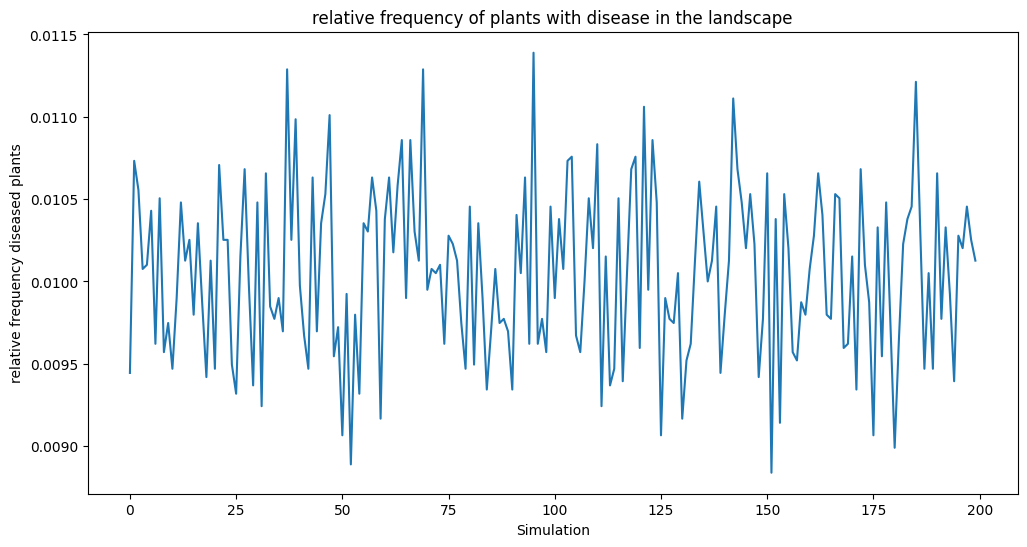

In [40]:
%precision 16

N = len(centrality_decile)
percent_v6 = 0
init_prob = 0.01
quartiles = [0.8]
#quartiles = [0.2, 0.4, 0.6, 0.8, 1]

def modify_array_by_quantile(percentage):
    N = len(centrality_decile)
    modified_arr = np.zeros(N, dtype=int)
    quartiles = np.unique(centrality_decile)
    
    for quart in quartiles:
        # Get indices for the current quartile
        indices = np.where(centrality_decile == quart)[0]
        n_yards_decile = len(indices)
        
        # Calculate the number of ones for this decile
        num_ones_decile = np.round(n_yards_decile * percentage).astype(int)
        
        # Create an array with the required number of ones and zeros
        decile_arr = np.array([1]*num_ones_decile + [0]*(n_yards_decile - num_ones_decile))
        
        # Shuffle the array to randomize the distribution
        np.random.shuffle(decile_arr)
        
        # Assign the shuffled array to the corresponding indices
        modified_arr[indices] = decile_arr
    
    return modified_arr.reshape(N, 1)

# Generate sI1_lag with the desired distribution
sI1_lag = modify_array_by_quantile(percent_v6)

prob_sim_list = []
y_0_list = []

mean_prob_sim_list = []

for quart in quartiles:
    
    # Number of yards in the current quantile
    num_yards_quantile = (centrality_decile == quart).sum()
    
    # Proportion of landscape in the current quantile
    prop_yards_quantile = num_yards_quantile / N
    
    # Proportion of yards in current quantile that may possess the v6 initial strain
    prop_v6 = sI1_lag[np.where(centrality_decile == quart)].mean()
    
    # Proportion of yards in current quantile that are susceptible to both v6 and non-v6 strains
    prop_susceptible_both = tI2[np.where(centrality_decile == quart)].mean()
    
    # Proportion of plants that are susceptible to disease in each quantile of the network
    prop_susceptible = prop_susceptible_both * (1 + prop_v6)
    
    # Adjust initial probability by concentrating infections in the susceptible yards and quantiles
    #adjusted_init_prob = init_prob * (1 / prop_susceptible) * (1 / prop_yards_quantile)
    adjusted_init_prob = init_prob * (1 / prop_susceptible) * (1 / prop_yards_quantile)
    print(adjusted_init_prob)
    prob_sim_list_ = []
    
    for i in range(200):
        
        y_0 = np.random.binomial(400, adjusted_init_prob, size=(N, 1))

        for k in range(N):
            if (y_0[k] > 0) and (tI1[k] == 1) and (sI1_lag[k] == 0):
                y_0[k] = 0
                
            if centrality_decile[k] != quart:
                y_0[k] = 0
                
        prob_sim = y_0.sum() / (400 * N)
        prob_sim_list.append(prob_sim)
        y_0_list.append(y_0)
        prob_sim_list_.append(prob_sim)
        
    mean_prob_sim_list.append(np.mean(prob_sim_list_))
    


# Highlight the points on the plot where the probability of disease is equal to 0
plt.figure(figsize=(12, 6))
plt.plot(prob_sim_list)
plt.xlabel('Simulation')
plt.ylabel('relative frequency diseased plants')
#plt.axhline(y=0.1, color='r', linestyle='--')
#plt.axhline(y=0, color='r', linestyle='--')
plt.title('relative frequency of plants with disease in the landscape')

# Highlight the points where the probability of disease is equal to 0
for i, prob in enumerate(prob_sim_list):
    if prob == 0:
        plt.scatter(i, 0, color='r', s=20)
 
# print mean of prob_sim_list formated number to avoid scientific notation
print("{:10f}".format(np.mean(prob_sim_list)))
      
plt.show()

In [41]:
y_0

array([[ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [41],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [29],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],

In [34]:
0.001/2/5

0.0001000000000000

In [449]:
0.5 * 0.2

0.1

In [447]:
1 - (1 - 0.5*0.2) ** (1 / 400)

0.0002633666020706027

### Leaf Incidence vs Plant Incidence

$$\text{leaf incidence} = 1-(1-p)^\frac{1}{n}$$

Where $p$ is the probability of disease, also known as the *plant incidence*.

In [ ]:
upper = 1-(1-lower)^n

0.005

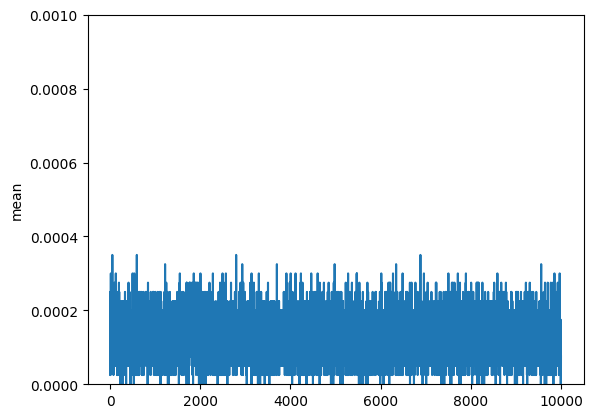

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Simulate this 100 times and plot the distribution of the mean
#N = 100  # Assuming N is defined somewhere in your code
n = 400
y_0_test = np.random.binomial(n, 0.000122951, size=(N, 10000))
means = (y_0_test / n).mean(axis=0)

# Create a DataFrame for Seaborn
df = pd.DataFrame({'mean': means})

# Plot using Seaborn
sns.lineplot(data=df, x=df.index, y='mean')
plt.ylim(0, 0.001)
plt.show()

In [123]:
N

100

In [177]:
%precision 10
sims = 10000
y_test1 = np.random.binomial(400, 0.0005, size=(int(N*0.20), sims))
y_test2 = np.zeros((int(N*0.80), sims))

y_0_test = np.concatenate([y_test1, y_test2])
y_0_test.sum() / (400*sims*100)

0.0001002825

In [186]:
y_0_test[:, 7].sum() / (400*100)

0.0001250000

In [176]:
0.0001 * 5

0.0005000000

In [162]:
y_0_test.shape

(100, 10000)

In [137]:


# plot line graph
plt.plot(y_0_test.sum / 400)

0.0075

# Graphs

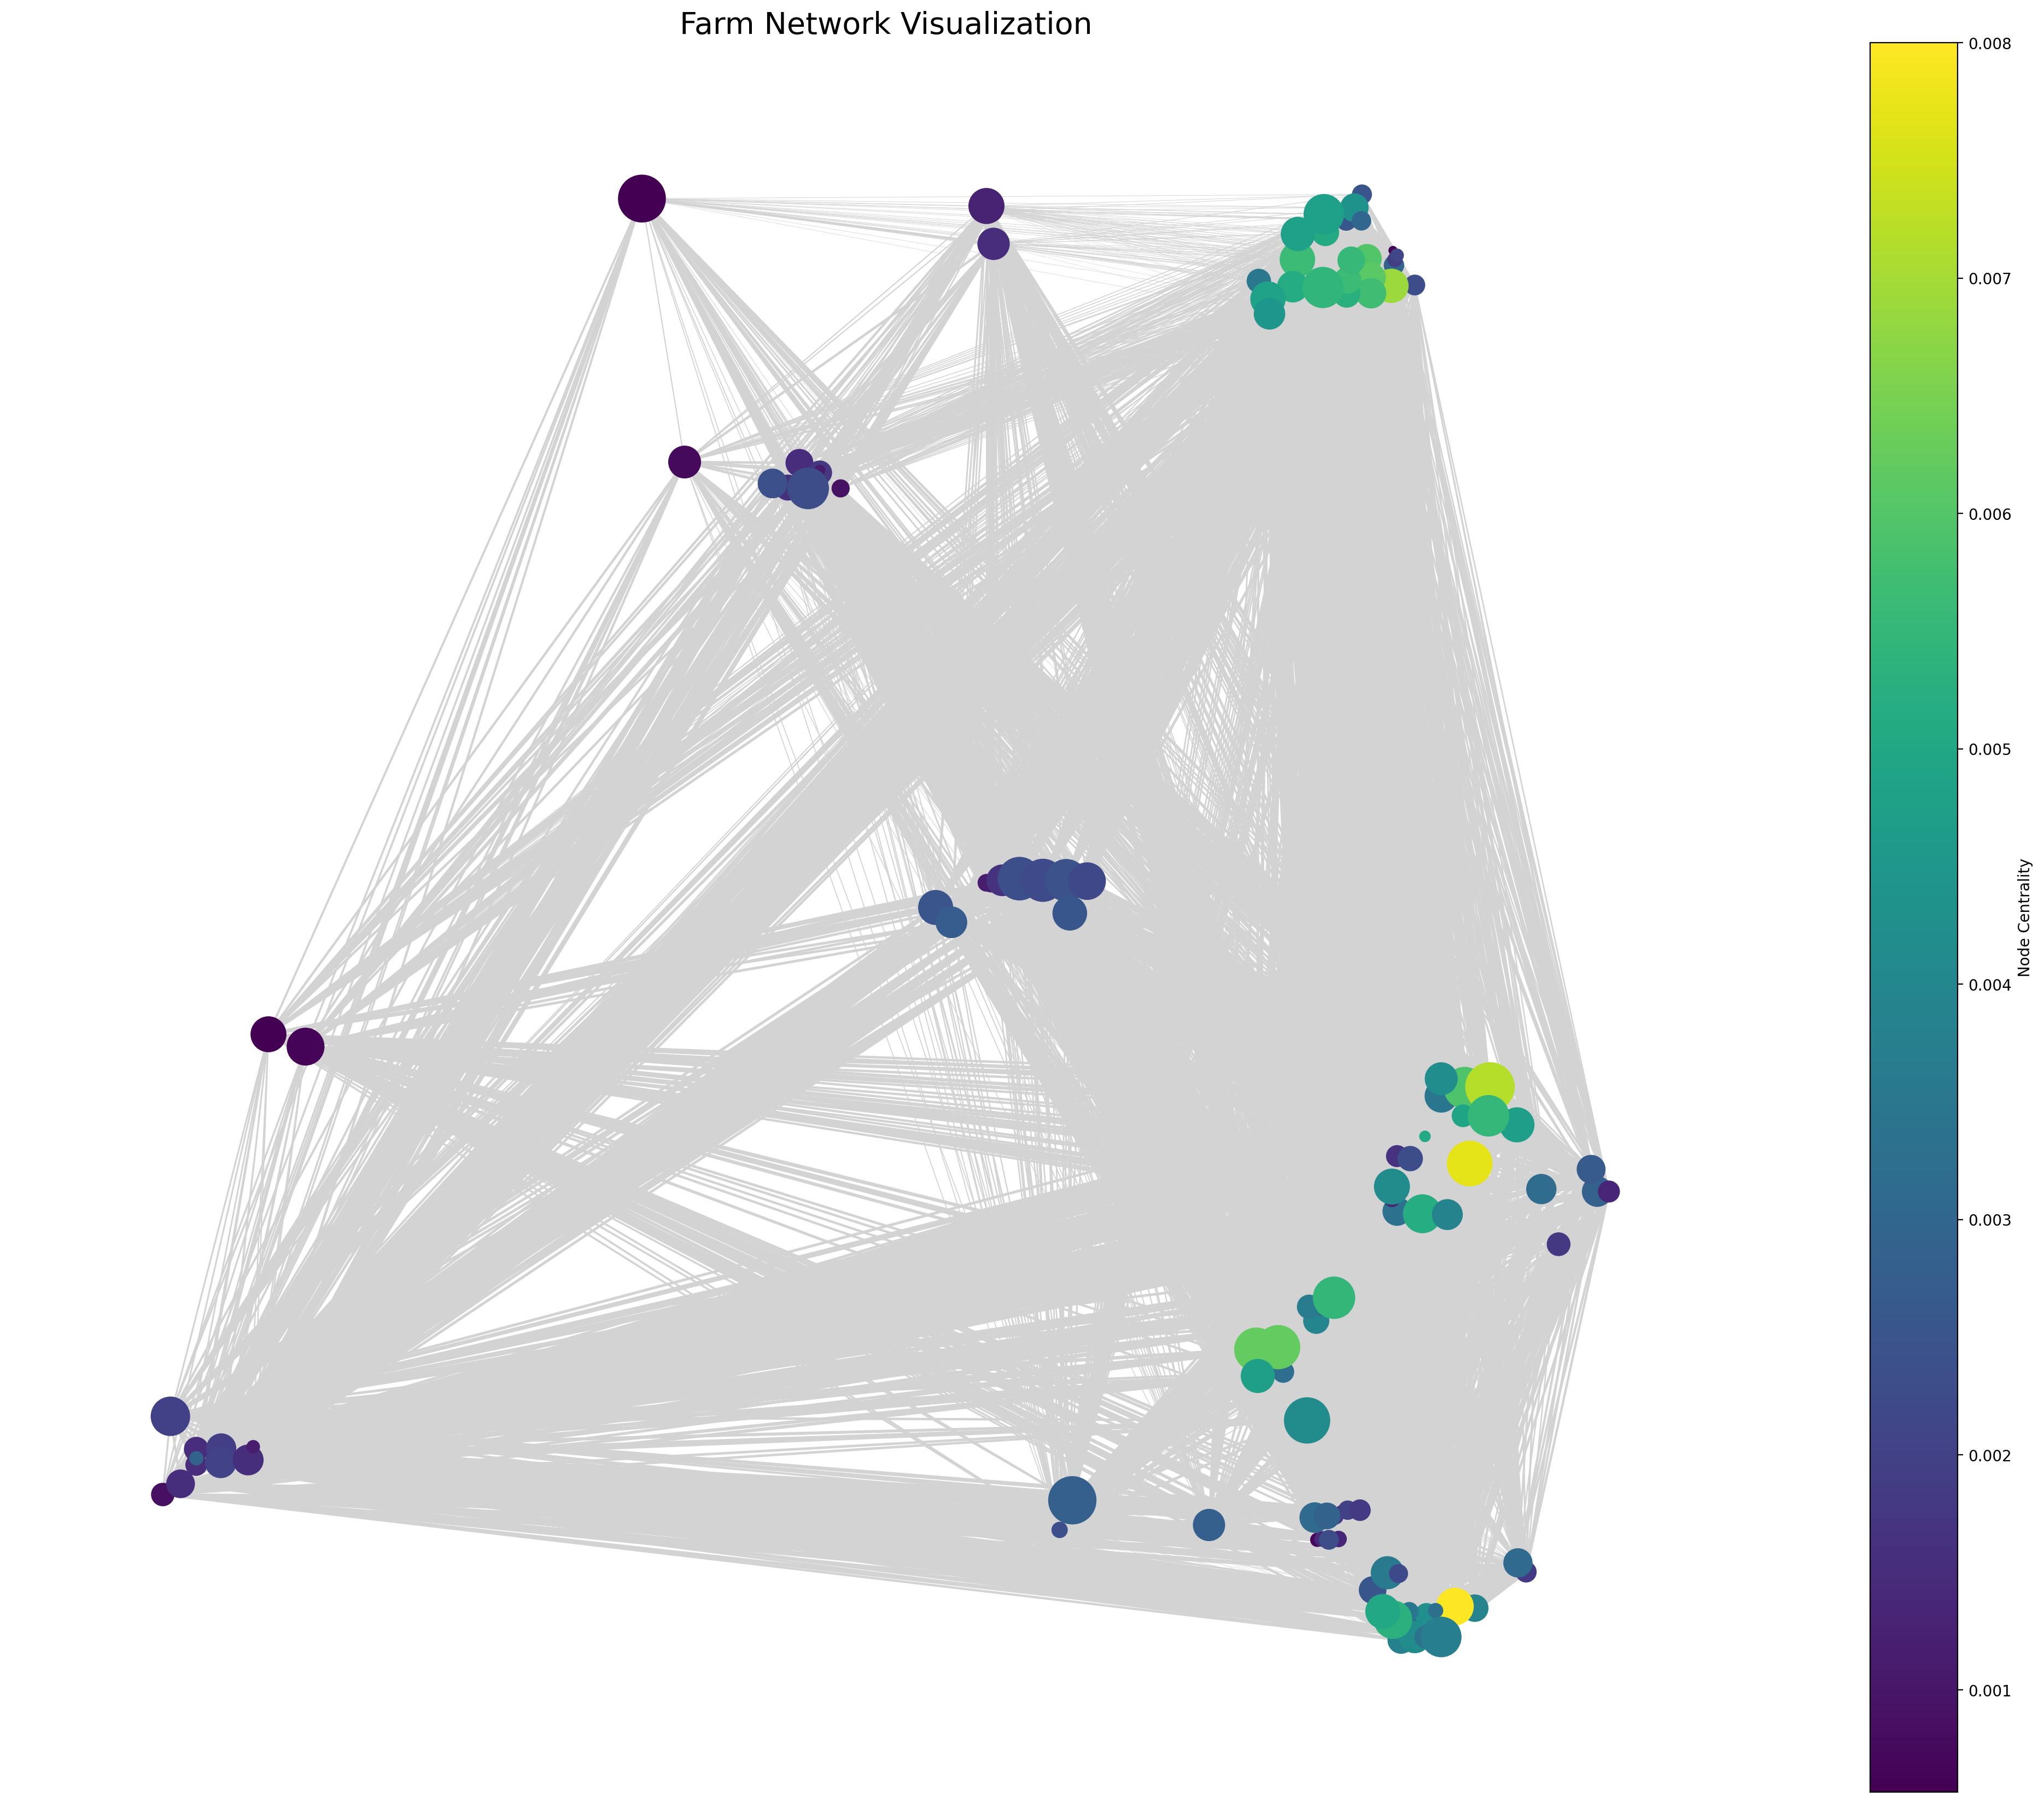

In [14]:
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.special import expit
from scipy.optimize import curve_fit


# Specify number of quantiles
num_quantiles = 5

# Centroid Latitude and Longitude Coordinates
coord = df[(df['Year'] == year) & (df['Month'] == 'May')][['Centroid Lat', 'Centroid Long']].reset_index(drop=True)

# Initialize graph
G = nx.Graph()

# Add nodes with their coordinates
for index, row in coord.iterrows():
    G.add_node(index, pos=(row['Centroid Long'], row['Centroid Lat']))


# min-max normalization for edge weights
w_may_norm = (w_may - np.min(w_may)) / (np.max(w_may) - np.min(w_may))
w_jun_norm = (w_jun - np.min(w_jun)) / (np.max(w_jun) - np.min(w_jun))
distance_norm = (distance - np.min(distance)) / (np.max(distance) - np.min(distance))
area_apr_norm = (area_apr - np.min(area_apr)) / (np.max(area_apr) - np.min(area_apr))

# Add edges with weights

for i in G.nodes():
    for j in G.nodes():
        if i < j:
            # area_i = area_apr_norm[i]
            # wind_run_ij = ((w_may_norm + w_jun_norm) / 2)[i, j]
            # distance_ij = distance_norm[i, j]
            
            area_i = area_apr[i]
            wind_run_ij = ((w_may + w_jun) / 2)[i, j]
            distance_ij = distance[i, j]
            
            weight = np.power(1 + distance_ij, -2) * area_i * wind_run_ij

            G.add_edge(i, j, weight=weight, wind_run=wind_run_ij)

# Calculate weighted degree centrality
weighted_degree_centrality = {node: sum(data['weight'] for _, _, data in G.edges(node, data=True)) for node in G.nodes()}

# Convert centrality to DataFrame
degree_centrality_df = pd.DataFrame(list(weighted_degree_centrality.items()), columns=['Node', 'Centrality'])
degree_centrality_df['Centrality'] = degree_centrality_df['Centrality'].apply(lambda x: x if np.isscalar(x) else x[0])

# Get node positions
pos = nx.get_node_attributes(G, 'pos')

# Prepare node sizes based on area
sizes = np.array([area[0] for area in area_apr])
sizes = 1000 * sizes / np.max(sizes)  # Scale sizes for visibility

# Prepare node colors based on centrality
cent = degree_centrality_df['Centrality'].values
normalize = mcolors.Normalize(vmin=cent.min(), vmax=cent.max())
colormap = cm.viridis

# Prepare edge widths based on wind run
edge_widths = [G[u][v]['wind_run'] for u, v in G.edges()]
max_width = max(edge_widths)
edge_widths = [width / max_width * 2 for width in edge_widths]  # Scale widths for visibility

# Create the plot
plt.figure(figsize=(20, 16), dpi=200)
nx.draw(G, pos, 
        node_size=sizes, 
        node_color=cent,
        cmap=colormap,
        width=edge_widths, 
        edge_color='lightgray',
        with_labels=False)

# Add a colorbar
sm = cm.ScalarMappable(norm=normalize, cmap=colormap)
sm.set_array([])
plt.colorbar(sm, label='Node Centrality', ax=plt.gca())

plt.title('Farm Network Visualization', fontsize=20)
plt.axis('off')

# Show the plot
plt.show()

# eigenvector centrality

Non-scalar weight for edge (0, 1): [0.01172048]
Non-scalar weight for edge (0, 2): [0.00598156]
Non-scalar weight for edge (0, 3): [0.01030975]
Non-scalar weight for edge (0, 4): [0.00918005]
Non-scalar weight for edge (0, 5): [0.00422975]
Non-scalar weight for edge (0, 6): [0.01041626]
Non-scalar weight for edge (0, 7): [0.01152168]
Non-scalar weight for edge (0, 8): [0.00772871]
Non-scalar weight for edge (0, 9): [0.00502576]
Non-scalar weight for edge (0, 10): [0.00500195]
Non-scalar weight for edge (0, 11): [0.00481856]
Non-scalar weight for edge (0, 12): [0.00477572]
Non-scalar weight for edge (0, 13): [0.00495392]
Non-scalar weight for edge (0, 14): [0.0102089]
Non-scalar weight for edge (0, 15): [0.00370982]
Non-scalar weight for edge (0, 16): [0.00376755]
Non-scalar weight for edge (0, 17): [0.00363072]
Non-scalar weight for edge (0, 18): [0.00306102]
Non-scalar weight for edge (0, 19): [0.01050218]
Non-scalar weight for edge (0, 20): [0.00444351]
Non-scalar weight for edge (0,

C:\Users\joshf\AppData\Local\Temp\ipykernel_23200\2735817435.py:100: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Eigenvalue Centrality')


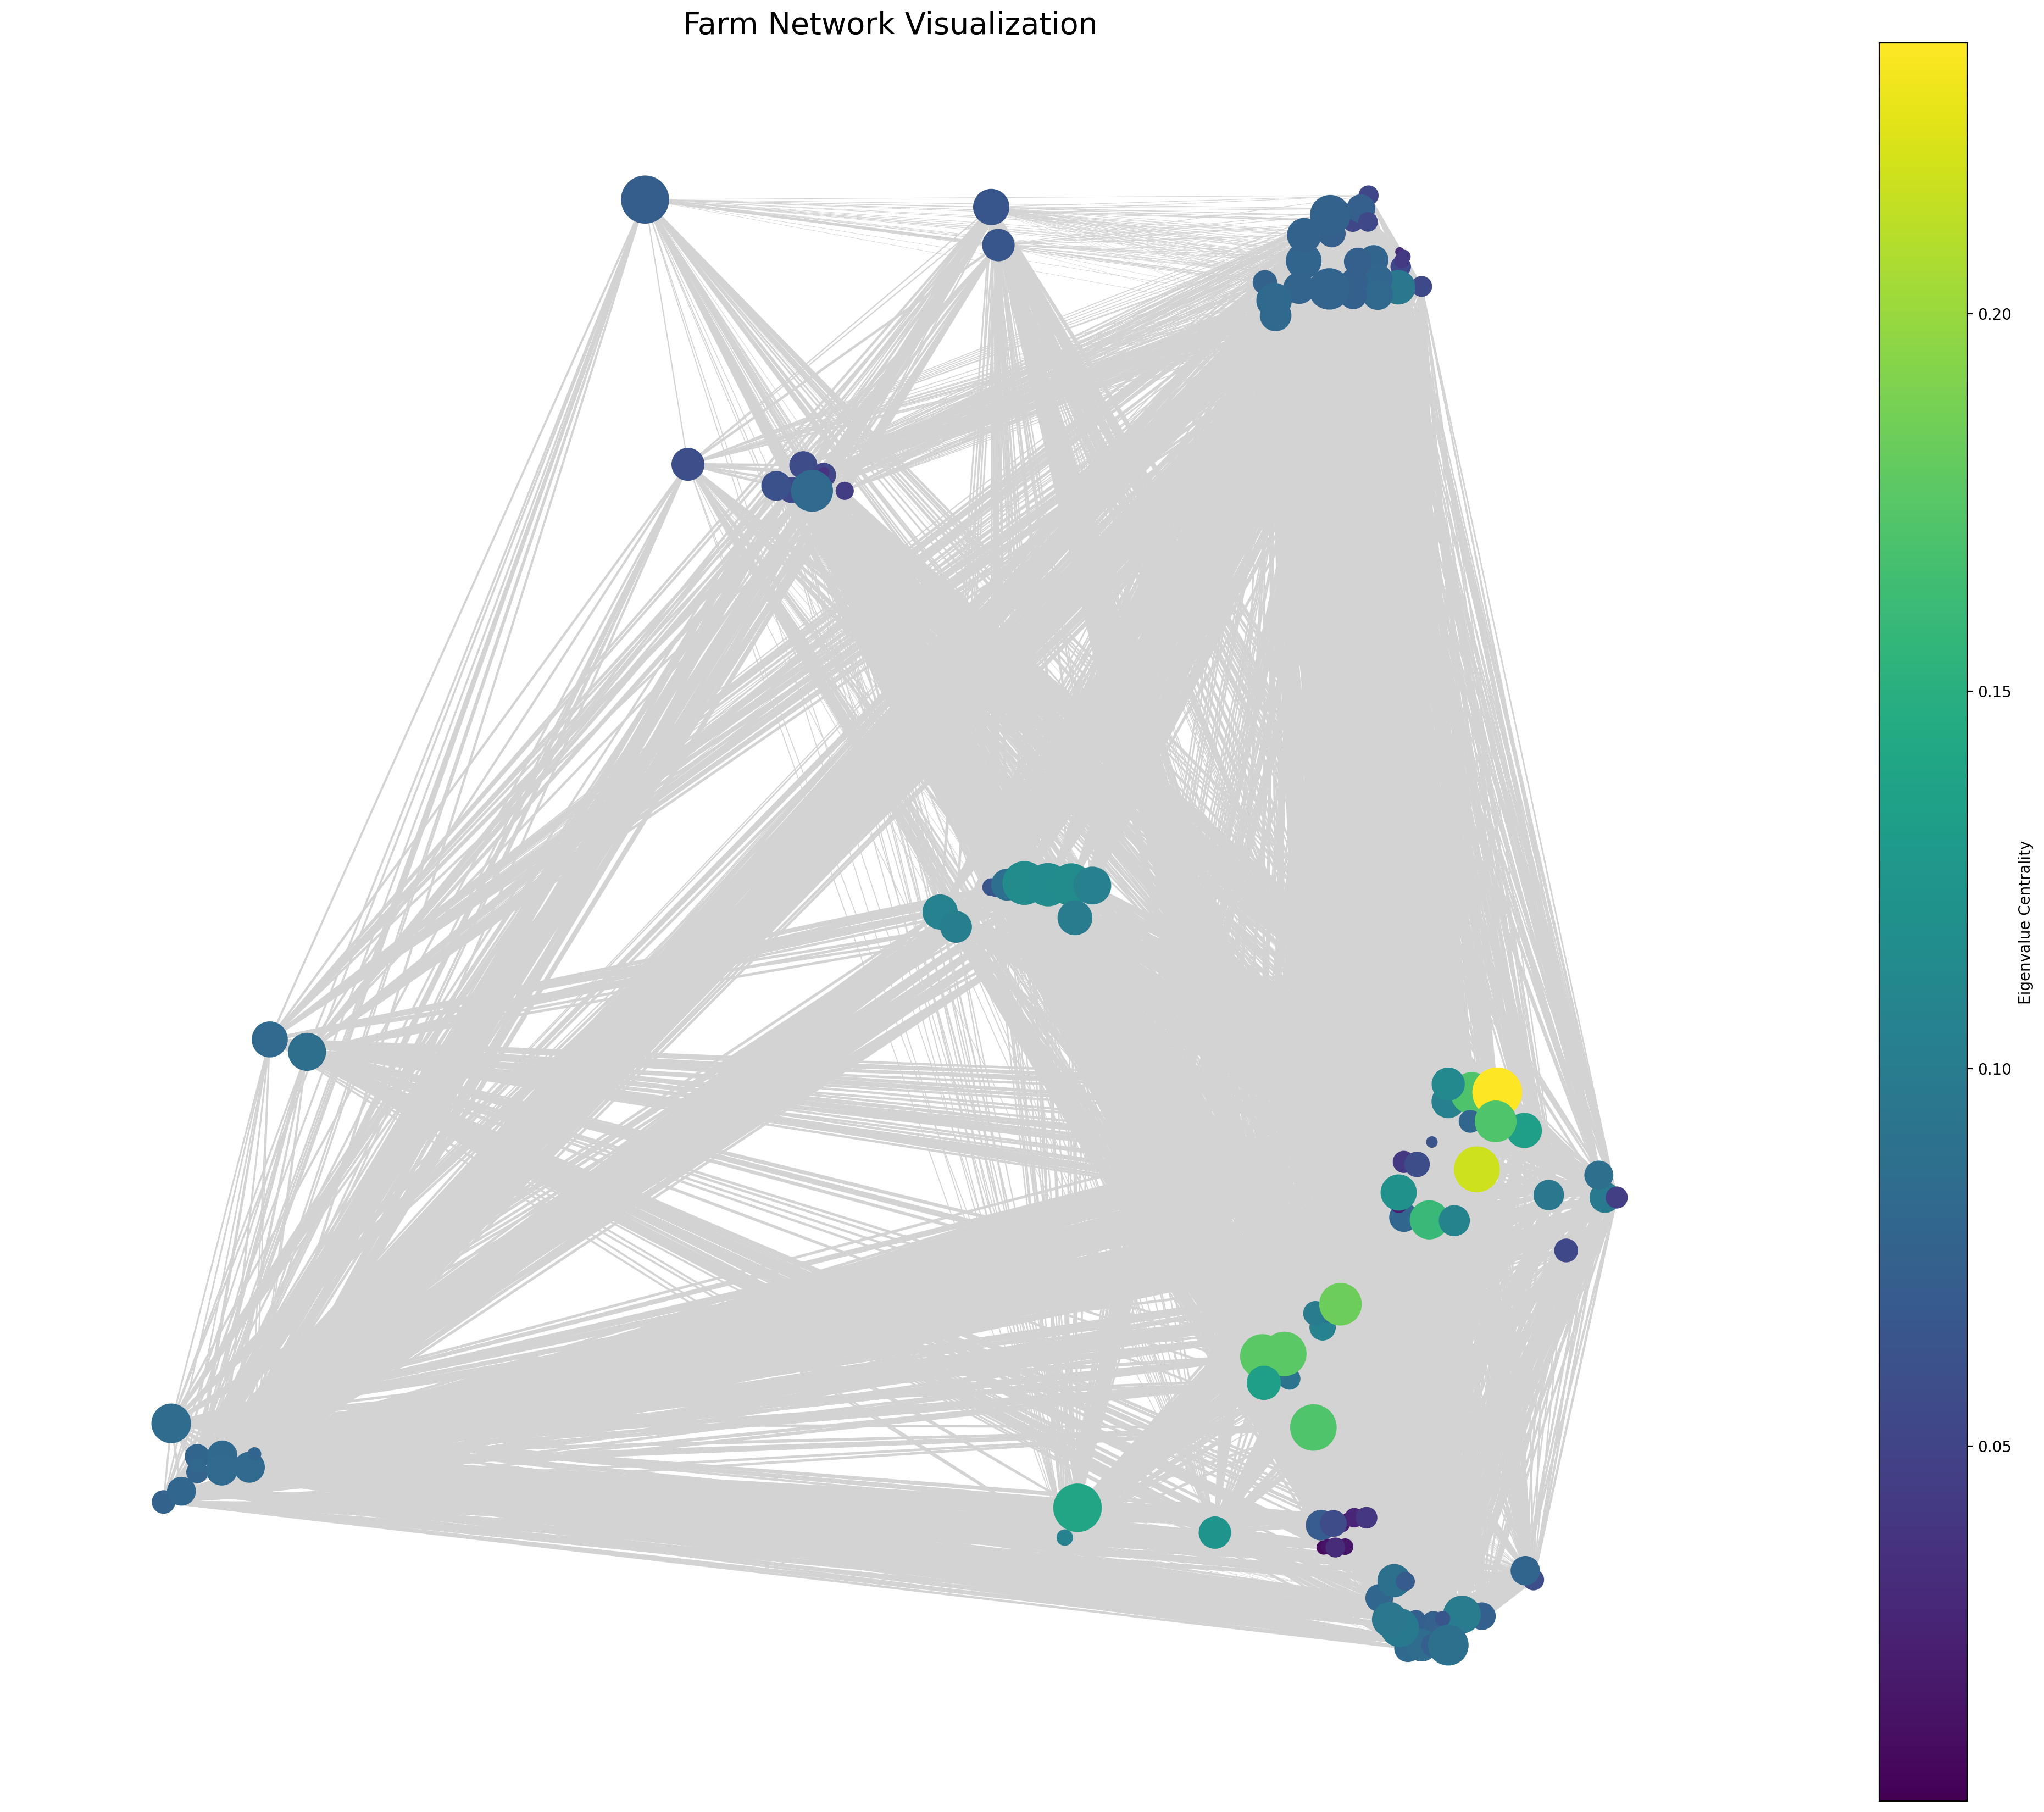

In [7]:
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.special import expit
from scipy.optimize import curve_fit

# Specify number of quantiles
num_quantiles = 5

# Centroid Latitude and Longitude Coordinates
coord = df[(df['Year'] == year) & (df['Month'] == 'May')][['Centroid Lat', 'Centroid Long']].reset_index(drop=True)

# Initialize graph
G = nx.Graph()

# Add nodes with their coordinates
for index, row in coord.iterrows():
    G.add_node(index, pos=(row['Centroid Long'], row['Centroid Lat']))

# min-max normalization for edge weights
w_may_norm = (w_may - np.min(w_may)) / (np.max(w_may) - np.min(w_may))
w_jun_norm = (w_jun - np.min(w_jun)) / (np.max(w_jun) - np.min(w_jun))
distance_norm = (distance - np.min(distance)) / (np.max(distance) - np.min(distance))
area_apr_norm = (area_apr - np.min(area_apr)) / (np.max(area_apr) - np.min(area_apr))

# Add edges with weights
for i in G.nodes():
    for j in G.nodes():
        if i < j:
            # area_i = area_apr[i]
            # wind_run_ij = ((w_may + w_jun) / 2)[i, j]
            # distance_ij = distance[i, j]
            
            area_i = area_apr_norm[i]
            wind_run_ij = ((w_may_norm + w_jun_norm) / 2)[i, j]
            distance_ij = distance_norm[i, j]
            
            weight = area_i * wind_run_ij * np.power(1 + distance_ij, -2)
            
            # Ensure weight is a scalar
            if not np.isscalar(weight):
                print(f"Non-scalar weight for edge ({i}, {j}): {weight}")
                weight = np.mean(weight)  # or another appropriate scalar value

            G.add_edge(i, j, weight=weight, wind_run=wind_run_ij)

# Debug: Check edge attributes
for (u, v, d) in G.edges(data=True):
    if not np.isscalar(d['weight']) or not np.isscalar(d['wind_run']):
        print(f"Edge ({u}, {v}) has non-scalar attributes: weight={d['weight']}, wind_run={d['wind_run']}")

# Calculate eigenvalue centrality
try:
    eigenvalue_centrality = nx.eigenvector_centrality_numpy(G, weight='weight')
except ValueError as e:
    print(f"Error in eigenvector centrality calculation: {e}")
    print("Falling back to unweighted eigenvector centrality")
    eigenvalue_centrality = nx.eigenvector_centrality_numpy(G)

# Convert centrality to DataFrame
centrality_df = pd.DataFrame(list(eigenvalue_centrality.items()), columns=['Node', 'Centrality'])

# Continue with the rest of your visualization code...

# Get node positions
pos = nx.get_node_attributes(G, 'pos')

# Prepare node sizes based on area
sizes = np.array([area[0] for area in area_apr])
sizes = 1000 * sizes / np.max(sizes)  # Scale sizes for visibility

# Prepare node colors based on centrality
cent = centrality_df['Centrality'].values
normalize = mcolors.Normalize(vmin=cent.min(), vmax=cent.max())
colormap = cm.viridis

# Prepare edge widths based on wind run
edge_widths = [G[u][v]['wind_run'] for u, v in G.edges()]
max_width = max(edge_widths)
edge_widths = [width / max_width * 2 for width in edge_widths]  # Scale widths for visibility

# Create the plot
plt.figure(figsize=(20, 16), dpi=200)
nx.draw(G, pos, 
        node_size=sizes, 
        node_color=cent,
        cmap=colormap,
        width=edge_widths, 
        edge_color='lightgray',
        with_labels=False)

# Add a colorbar
sm = cm.ScalarMappable(norm=normalize, cmap=colormap)
sm.set_array([])
plt.colorbar(sm, label='Eigenvalue Centrality')

plt.title('Farm Network Visualization', fontsize=20)
plt.axis('off')

# Show the plot
plt.show()

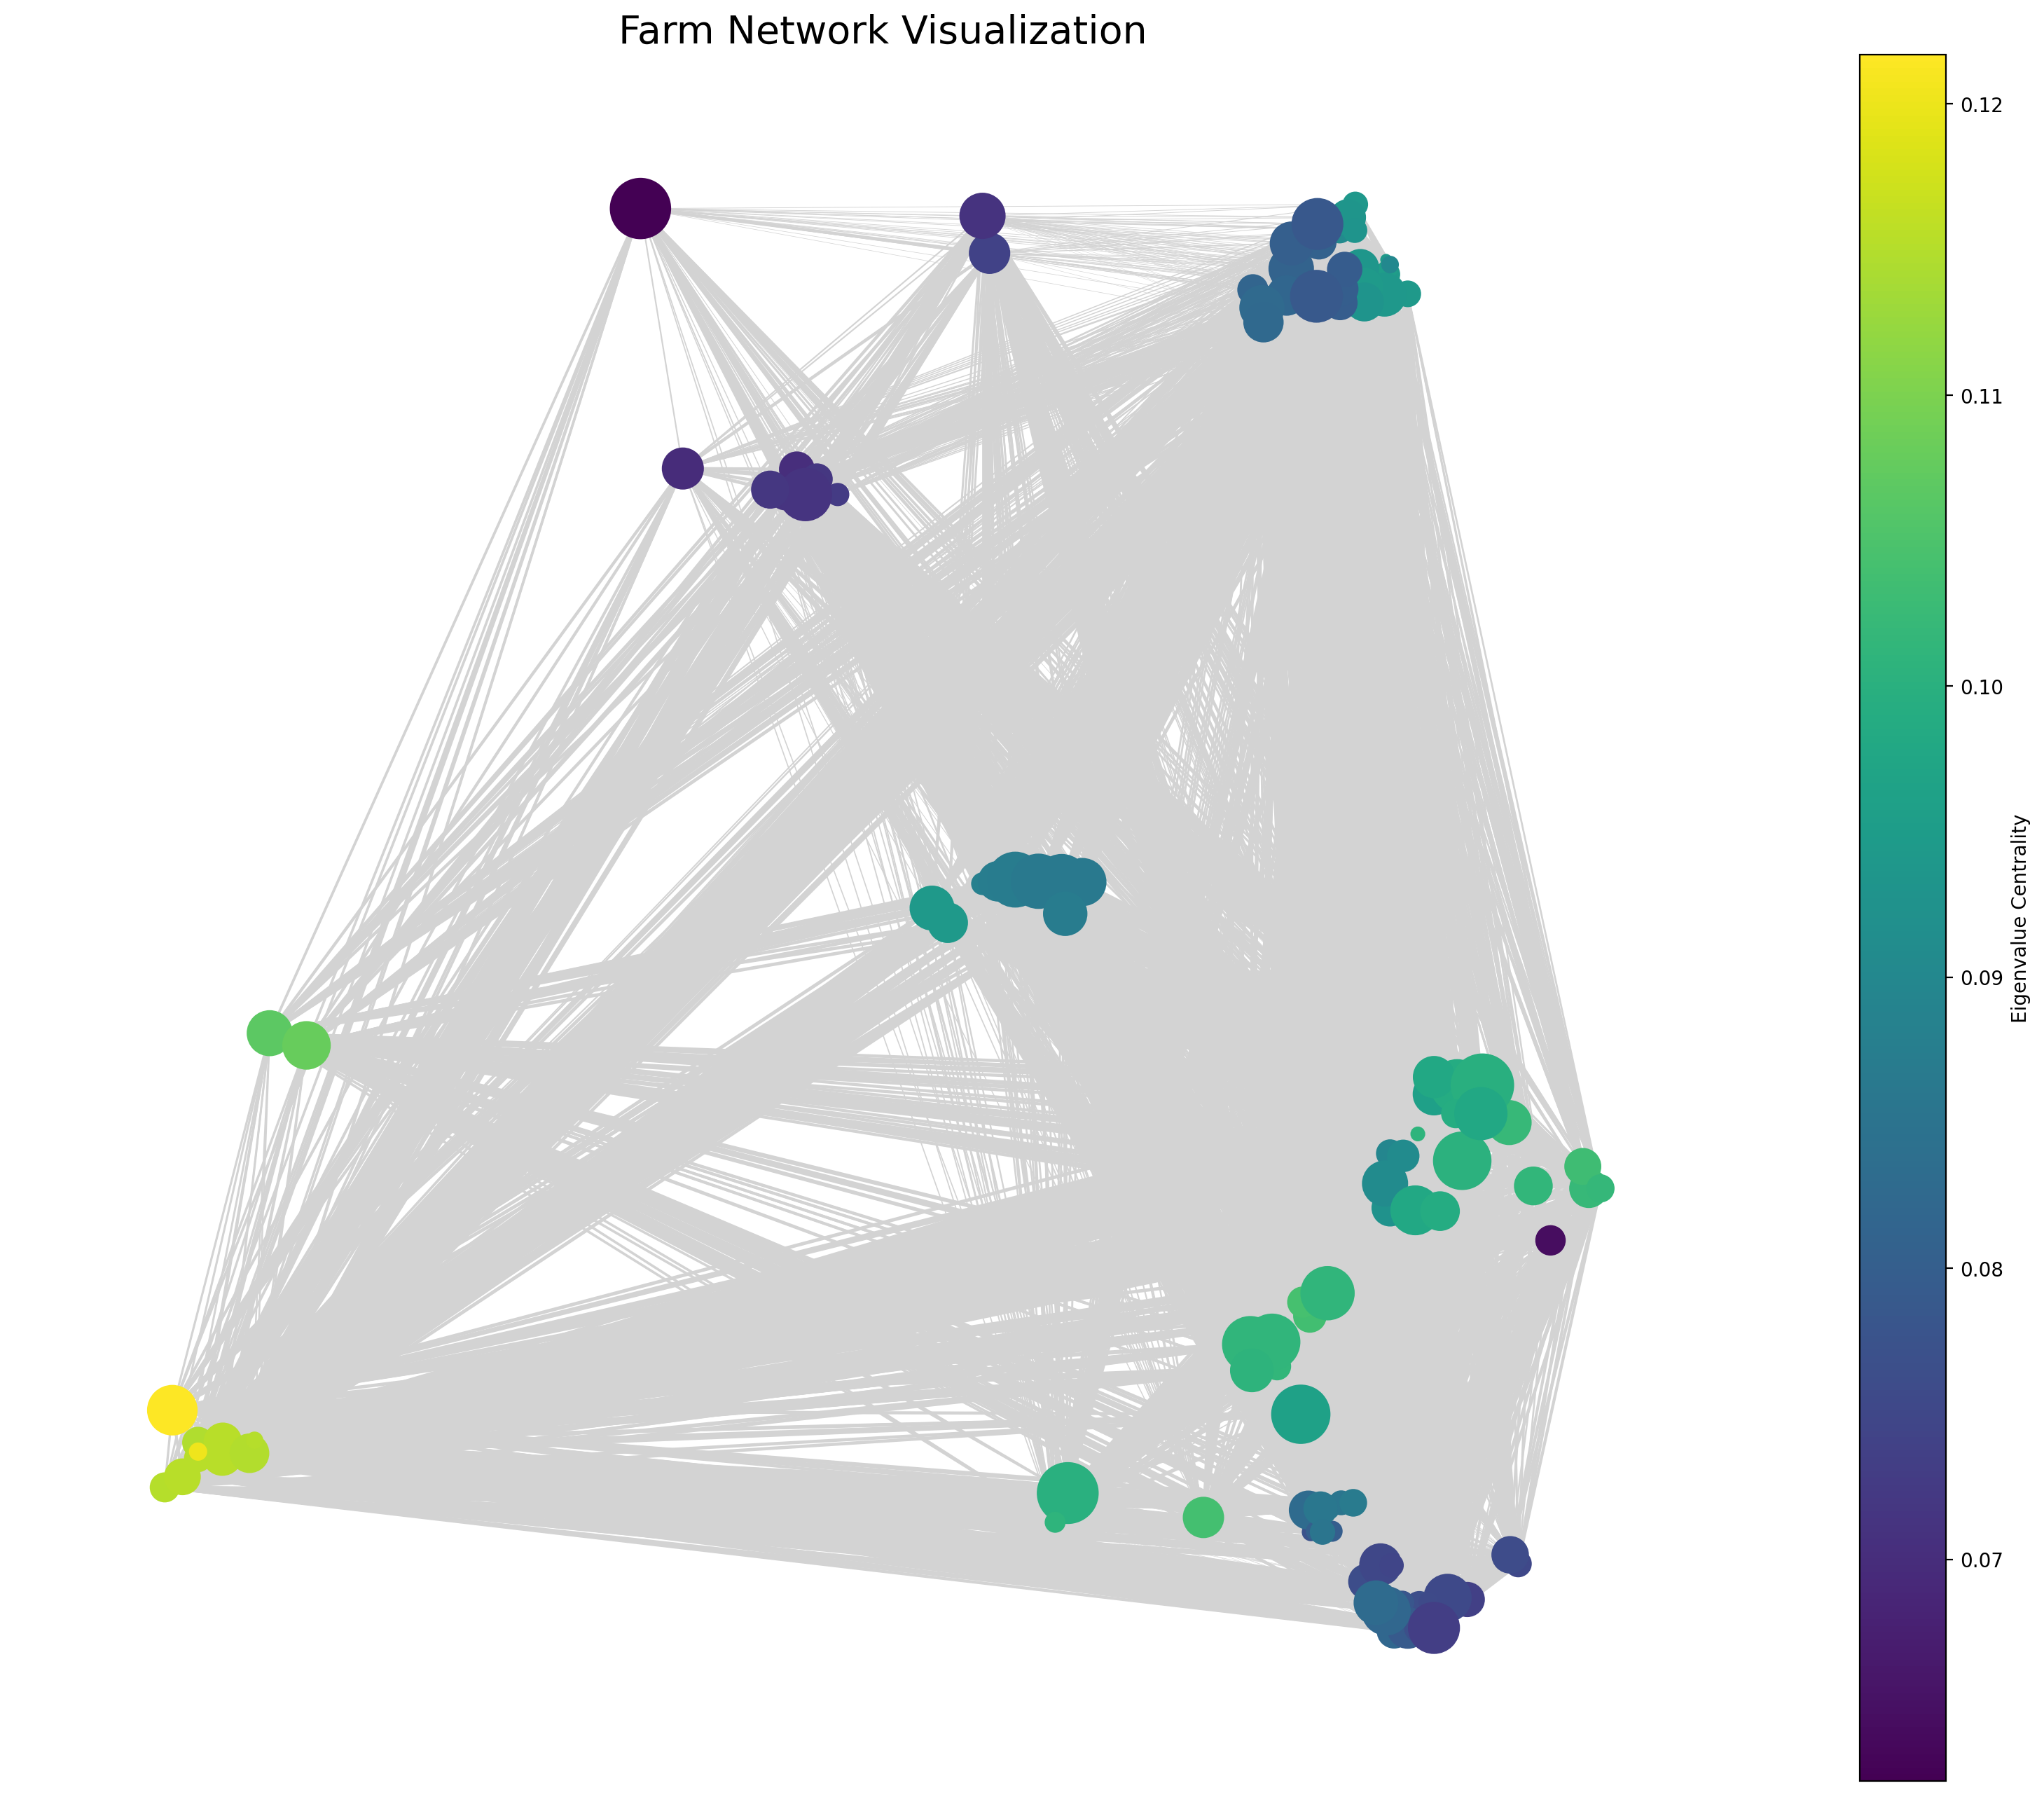

In [12]:
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.special import expit
from scipy.optimize import curve_fit

# Specify number of quantiles
num_quantiles = 5

# Centroid Latitude and Longitude Coordinates
coord = df[(df['Year'] == year) & (df['Month'] == 'May')][['Centroid Lat', 'Centroid Long']].reset_index(drop=True)

# Initialize graph
G = nx.Graph()

# Add nodes with their coordinates
for index, row in coord.iterrows():
    G.add_node(index, pos=(row['Centroid Long'], row['Centroid Lat']))

# min-max normalization for edge weights
w_may_norm = (w_may - np.min(w_may)) / (np.max(w_may) - np.min(w_may))
w_jun_norm = (w_jun - np.min(w_jun)) / (np.max(w_jun) - np.min(w_jun))
distance_norm = (distance - np.min(distance)) / (np.max(distance) - np.min(distance))
area_apr_norm = (area_apr - np.min(area_apr)) / (np.max(area_apr) - np.min(area_apr))

# unit vector normalization
w_may_norm = w_may / np.linalg.norm(w_may)
w_jun_norm = w_jun / np.linalg.norm(w_jun)
distance_norm = distance / np.linalg.norm(distance)
area_apr_norm = area_apr / np.linalg.norm(area_apr)

# Add edges with weights
for i in G.nodes():
    for j in G.nodes():
        if i < j:
            area_i = area_apr[i]
            wind_run_ij = ((w_may + w_jun) / 2)[i, j]
            distance_ij = distance[i, j]
            
            # area_i = area_apr_norm[i]
            # wind_run_ij = ((w_may_norm + w_jun_norm) / 2)[i, j]
            # distance_ij = distance_norm[i, j]
            
            # Ensure weight is a scalar
            weight = float(area_i * wind_run_ij * np.power(1 + distance_ij, -2))
            weight = float(wind_run_ij)

            G.add_edge(i, j, weight=weight, wind_run=float(wind_run_ij))

# Calculate eigenvalue centrality
eigenvalue_centrality = nx.eigenvector_centrality_numpy(G, weight='weight')

# Convert centrality to DataFrame
centrality_df = pd.DataFrame(list(eigenvalue_centrality.items()), columns=['Node', 'Centrality'])

# Get node positions
pos = nx.get_node_attributes(G, 'pos')

# Prepare node sizes based on area
sizes = np.array([area[0] for area in area_apr])
sizes = 1000 * sizes / np.max(sizes)  # Scale sizes for visibility

# Prepare node colors based on centrality
cent = centrality_df['Centrality'].values
normalize = mcolors.Normalize(vmin=cent.min(), vmax=cent.max())
colormap = cm.viridis

# Prepare edge widths based on wind run
edge_widths = [G[u][v]['wind_run'] for u, v in G.edges()]
max_width = max(edge_widths)
edge_widths = [width / max_width * 2 for width in edge_widths]  # Scale widths for visibility

# Create the plot
fig, ax = plt.subplots(figsize=(20, 16), dpi=200)
nx.draw(G, pos, 
        node_size=sizes, 
        node_color=cent,
        cmap=colormap,
        width=edge_widths, 
        edge_color='lightgray',
        with_labels=False,
        ax=ax)

# Add a colorbar
sm = cm.ScalarMappable(norm=normalize, cmap=colormap)
sm.set_array([])
plt.colorbar(sm, label='Eigenvalue Centrality', ax=ax)

plt.title('Farm Network Visualization', fontsize=20)
plt.axis('off')

# Show the plot
plt.show()

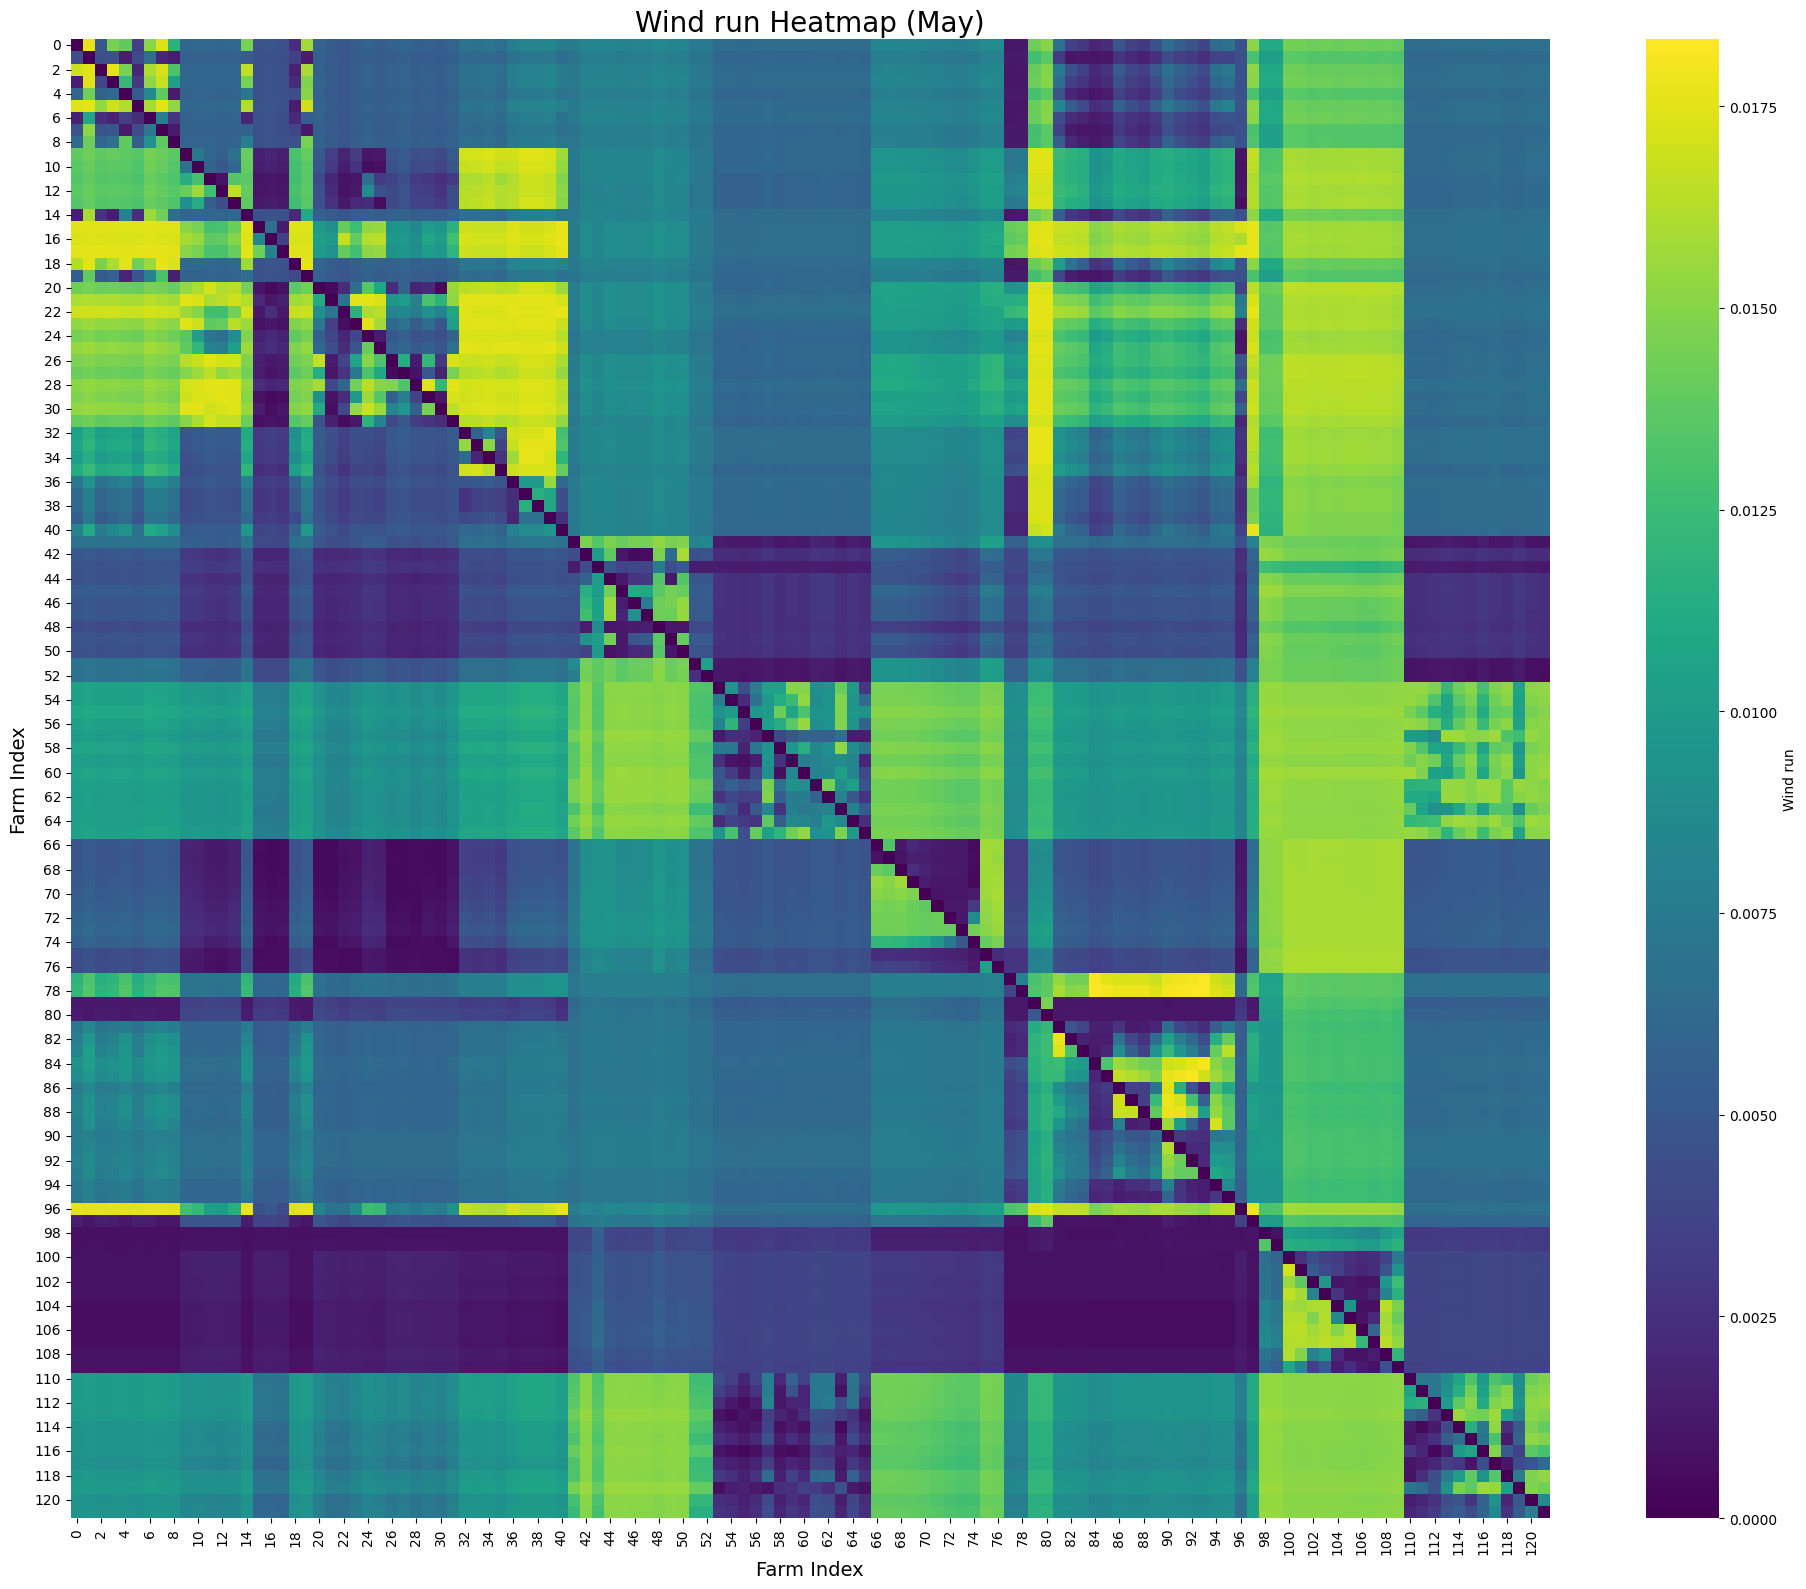

Wind Data Statistics:
Minimum wind run: 0.00
Maximum wind run: 0.02
Average wind run: 0.01
Median wind run: 0.01


In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming w_may is already loaded as a 122x122 numpy array

# Create a DataFrame from the w_may array
df_wind = pd.DataFrame(w_may)

# Set up the matplotlib figure
plt.figure(figsize=(20, 16))

# Create the heatmap
sns.heatmap(df_wind, cmap="viridis", cbar_kws={'label': 'Wind run'})

# Set title and labels
plt.title("Wind run Heatmap (May)", fontsize=20)
plt.xlabel("Farm Index", fontsize=14)
plt.ylabel("Farm Index", fontsize=14)

# Improve the aspect ratio
plt.gca().set_aspect('equal')

# Show the plot
plt.tight_layout()
plt.show()

# Print some statistics about the wind data
print("Wind Data Statistics:")
print(f"Minimum wind run: {np.min(w_may):.2f}")
print(f"Maximum wind run: {np.max(w_may):.2f}")
print(f"Average wind run: {np.mean(w_may):.2f}")
print(f"Median wind run: {np.median(w_may):.2f}")

In [41]:
area_apr

array([[ 0.68796665],
       [ 1.49733919],
       [ 0.89030979],
       [ 2.38764898],
       [ 1.25452743],
       [ 2.95420975],
       [ 7.76997633],
       [ 1.86155683],
       [ 2.06389996],
       [ 7.00107242],
       [ 2.02343133],
       [ 3.88498816],
       [ 5.26092147],
       [11.00746646],
       [ 5.86795087],
       [ 7.85091358],
       [ 6.92013517],
       [ 3.88498816],
       [ 3.72311366],
       [ 3.11608426],
       [ 9.30778414],
       [10.44090569],
       [ 7.64857045],
       [18.00853888],
       [12.94996054],
       [ 8.01278809],
       [15.09479776],
       [ 9.14590963],
       [21.32696627],
       [ 4.16826855],
       [14.81151737],
       [ 0.93077841],
       [ 5.62513911],
       [ 3.39936464],
       [ 4.8562352 ],
       [15.4590154 ],
       [ 3.84451954],
       [16.87541733],
       [16.87541733],
       [ 9.83387629],
       [18.53463103],
       [ 8.78169199],
       [ 6.43451164],
       [19.87009571],
       [ 5.54420186],
       [ 2

  0.000990


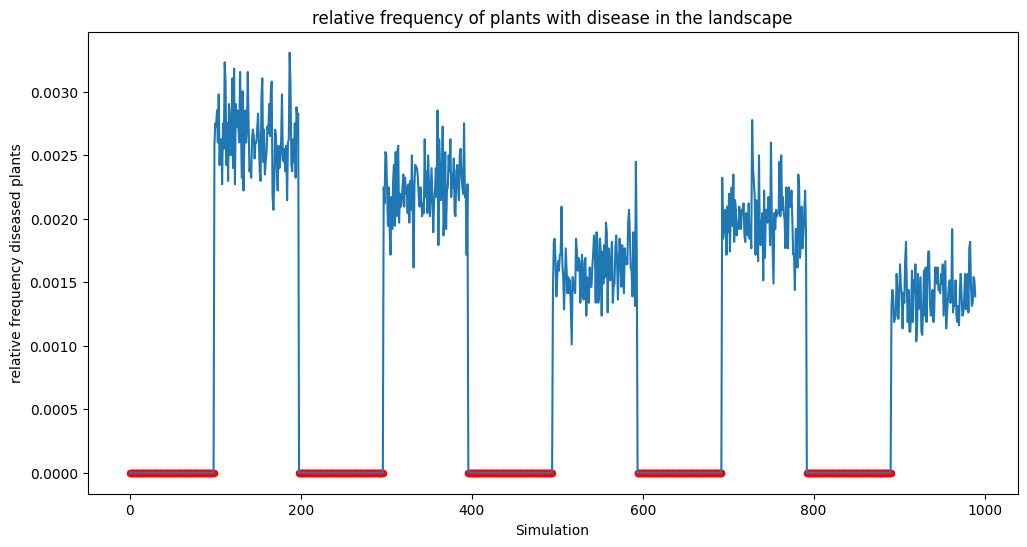

In [8]:
%precision 16

N = len(centrality_decile)
percent_v6 = 0
initial_prob = 0.001 * 2 * (1 - percent_v6) * 10
quartiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# Create a numpy array of shape (N, 3) with randomly assigned values [0, 1, variety] and [1, 0, variety]
arr = np.zeros((N, 3))

if N % 2 == 0:
    arr[:int(N/2), 0] = 1
    arr[int(N/2):, 1] = 1
    arr[:int(N/4), 2] = 0  # chinook
    arr[int(N/4):int(N/2), 2] = 1  # simcoe
    arr[int(N/2):int(3*N/4), 2] = 2  # mosaic
    arr[int(3*N/4):, 2] = 3  # nugget
else:
    arr[:int((N+1)/2), 0] = 1
    arr[int((N-1)/2):, 1] = 1
    arr[:int((N+1)/4), 2] = 0  # chinook
    arr[int((N+1)/4):int((N+1)/2), 2] = 1  # simcoe
    arr[int((N-1)/2):int((3*N-1)/4), 2] = 2  # mosaic
    arr[int((3*N-1)/4):, 2] = 3  # nugget

# Shuffle the array
np.random.shuffle(arr)

# Split the columns into three (N, 1) arrays
tI1 = arr[:, 0].reshape(N, 1)
tI2 = arr[:, 1].reshape(N, 1)
tI3 = arr[:, 2].reshape(N, 1)

# Create a dictionary for plant varieties
variety_dict = {0: 'chinook', 1: 'simcoe', 2: 'mosaic', 3: 'nugget'}

# Replace plant variety numbers with their names
variety_array = np.vectorize(variety_dict.get)(tI3)

def modify_array(arr, percentage):
    # Calculate the number of ones
    num_ones = int(len(arr) * percentage)
    
    # Create an array with the required number of ones and the rest zeros
    modified_arr = np.array([1]*num_ones + [0]*(len(arr)-num_ones))
    
    # Shuffle the array
    np.random.shuffle(modified_arr)
    
    modified_arr = modified_arr.reshape(N,1)
    
    return modified_arr

sI1_lag = modify_array(np.zeros((N,1)), percent_v6)

prob_sim_list = []
y_0_list = []

mean_prob_sim_list = []

for quart in quartiles:
    
    prob_sim_list_ = []
    
    for i in range(N):
        
        y_0 = np.random.binomial(400, initial_prob, size=(N, 1))

        for k in range(N):
            if (y_0[k] > 0) and (variety_array[k] == 'nugget') and (sI1_lag[k] == 0):
                y_0[k] = 0
                
            if (y_0[k] > 0) and (variety_array[k] == 'mosaic') and (sI1_lag[k] == 0):
                y_0[k] = 0
                
            if centrality_decile[k] != quart:
                y_0[k] = 0
                
        prob_sim = y_0.sum() / (400 * N)
        prob_sim_list.append(prob_sim)
        y_0_list.append(y_0)
        prob_sim_list_.append(prob_sim)
        
    mean_prob_sim_list.append(np.mean(prob_sim_list_))
    


# Highlight the points on the plot where the probability of disease is equal to 0
plt.figure(figsize=(12, 6))
plt.plot(prob_sim_list)
plt.xlabel('Simulation')
plt.ylabel('relative frequency diseased plants')
#plt.axhline(y=0.1, color='r', linestyle='--')
#plt.axhline(y=0, color='r', linestyle='--')
plt.title('relative frequency of plants with disease in the landscape')

# Highlight the points where the probability of disease is equal to 0
for i, prob in enumerate(prob_sim_list):
    if prob == 0:
        plt.scatter(i, 0, color='r', s=20)
 
# print mean of prob_sim_list formated number to avoid scientific notation
print("{:10f}".format(np.mean(prob_sim_list)))
      
plt.show()

In [42]:
0.2*122

24.4000000000000021

In [22]:
0.0001 * 0.5 * 0.1 * 2 * 10

0.0001000000000000

In [20]:
mean_prob_sim_list

[0.0000058787960226,
 0.0000048710024187,
 0.0000052069336200,
 0.0000055428648213,
 0.0000050389680193,
 0.0000085662456329,
 0.0000043671056168,
 0.0000036952432142,
 0.0000048710024187,
 0.0000043671056168]

In [14]:
np.where(np.array(prob_sim_list) == 0)

(array([   0,    1,    2,    3,    4,    5,    6,    7,    8,   10,   11,
          12,   13,   14,   16,   17,   20,   22,   24,   25,   26,   27,
          29,   30,   31,   34,   35,   37,   38,   39,   40,   41,   42,
          43,   44,   45,   48,   50,   51,   53,   59,   60,   61,   62,
          63,   64,   65,   67,   68,   69,   70,   71,   73,   74,   77,
          78,   79,   80,   81,   83,   84,   86,   87,   89,   90,   93,
          95,   96,   97,   98,   99,  100,  101,  102,  104,  105,  106,
         109,  110,  111,  112,  113,  114,  117,  119,  120,  121,  124,
         125,  126,  128,  130,  132,  133,  135,  136,  137,  138,  139,
         142,  143,  144,  145,  147,  148,  149,  150,  153,  155,  157,
         158,  159,  161,  165,  167,  168,  171,  173,  174,  175,  177,
         179,  180,  182,  184,  186,  187,  188,  189,  190,  191,  192,
         194,  195,  196,  198,  199,  201,  203,  204,  205,  207,  208,
         209,  210,  211,  212,  213, 

In [1277]:
# import data from csv
dff = pd.read_csv('../data/raw/data_2017_v2.csv', encoding='cp1252')

In [1284]:
dff['Flag shoot incidence']

# drop rows with '.' in Flag shoot incidence
dff = dff[dff['Flag shoot incidence'] != '.']
dff['Flag shoot incidence'] = dff['Flag shoot incidence'].astype(float)

In [1508]:
mean_list = []
for i in range(1, 100):    
    themean = dff.loc[(dff['Month'] == 'May') & (dff['Year'] == 2014) & ((dff['Initial Strain'] == 'R6') | (dff['Initial Strain'] == 'non-R6')), 'Flag shoot incidence'].mean()
    mean_list.append(themean)
    
np.mean(mean_list)

0.0024324324324324

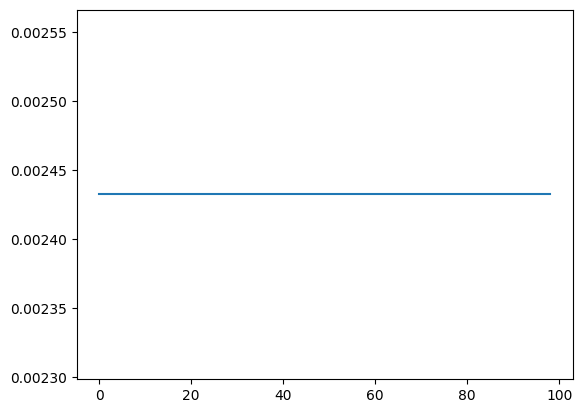

In [1509]:
# Plot mean_list
plt.plot(mean_list)